In [67]:
#https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218
# note: I trained on alice in wonderland, about 1/4 the length of his Nietzsche data set.
# I also tested with "seeds" that come from his Nietzsche examples!
# TODO - why does validation not go down?   
#    - what happens if you let it run further by itself? 
#   - Use  GRU instead of LSTM

import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, GRU, Dropout,BatchNormalization
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
from keras import regularizers
import matplotlib.pyplot as plt
import pickle
import sys
import os

from keras.callbacks import ModelCheckpoint

import heapq
import seaborn as sns
from pylab import rcParams


%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

In [68]:
#trainP=True
useNietzsche=False
useCarroll=True
useShakespeare=False

LOGDIR="FTP"
RUNNAME="minishakespeareStep3Seq50"
FILENAME=LOGDIR + "/" + RUNNAME

#get parameters from training param file
with open(FILENAME + '.params.pkl', 'rb') as f:  
    param = pickle.load(f)
for key, value in param.items():
    print(key,  " : ", value)

#assign the ones we need for analysis & visualization
SEQUENCE_LENGTH = param['SEQUENCE_LENGTH']
EPOCHS = param['EPOCHS']
step = param['step']
layer1size = param['layer1size']

# paramaeters for reconstructions
topN=1
topNStartWord=3
k_phraseLength=100

k_condNietzsche=[1,0,0]
k_condCarroll=[0,1,0]
k_condShakespeare=[0,0,1]

# get derived parameters for reconstruction
chars = param['chars']
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
lenchars=len(chars)
lenconditional=len(k_condNietzsche)
lenAugmentedInput=lenchars+lenconditional




FILENAME  :  LOG/minishakespeareStep3Seq50
RUNNAME  :  minishakespeareStep3Seq50
SEQUENCE_LENGTH  :  5
EPOCHS  :  1
step  :  3
layer1size  :  128
k_layers  :  3
k_bn  :  True
k_batchsize  :  128
k_lr  :  0.005
k_stateful  :  False
k_shuffle  :  True
k_validationSplit  :  0.0999689537410742
chars  :  ['\n', ' ', '$', "'", ',', '-', '.', ':', ';', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [69]:

modelOrig = load_model(FILENAME + '.keras_model.h5')
history = pickle.load(open(FILENAME + '.history.p', "rb"))


In [70]:
#for making predictions, we need a model that can take in a batch size of 1
# construct a new model and copy weights.

k_layers = param['k_layers']
layer1size = param['layer1size']
k_stateful = param['k_stateful']
SEQUENCE_LENGTH = param['SEQUENCE_LENGTH']
k_bn = param['k_bn']

k_batchsize=1 # THIS IS THe DIFFERENCe FROM THE SAVECD MODEL

model = Sequential()

for i in range(k_layers) :
    #if last layer, don't return sequence
    if i==(k_layers-1) :
        model.add(LSTM(layer1size,  batch_size=k_batchsize, stateful=k_stateful, input_shape=(SEQUENCE_LENGTH, lenAugmentedInput)))
    else :
        model.add(LSTM(layer1size,   batch_size=k_batchsize, stateful=k_stateful, return_sequences=True, input_shape=(SEQUENCE_LENGTH, lenAugmentedInput)))
        
    #FAIL model.add(LSTM(layer1size, dropout=0.25, recurrent_dropout=0.25, input_shape=(SEQUENCE_LENGTH, lenAugmentedInput)))
    #FAIL model.add(GRU(layer1size,  input_shape=(SEQUENCE_LENGTH, lenAugmentedInput), kernel_regularizer=regularizers.l2(0.1), recurrent_regularizer=regularizers.l2(0.1), bias_regularizer=regularizers.l2(0.1), activity_regularizer=regularizers.l2(0.1)))

    if (k_bn) : 
        model.add(BatchNormalization())

#model.add(Dense(lenchars, kernel_regularizer=regularizers.l2(0.1),  bias_regularizer=regularizers.l2(0.1), activity_regularizer=regularizers.l2(0.1)))
#model.add(Dense(lenchars, kernel_regularizer=regularizers.l2(0.1),  bias_regularizer=regularizers.l2(0.1), activity_regularizer=regularizers.l2(0.1)))
model.add(Dense(lenchars))
model.add(Activation('softmax'))



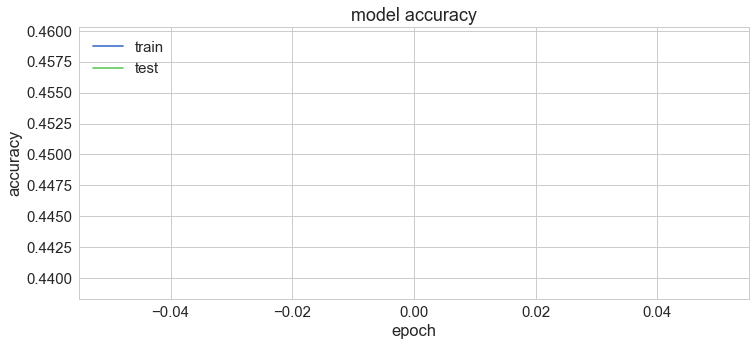

In [71]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

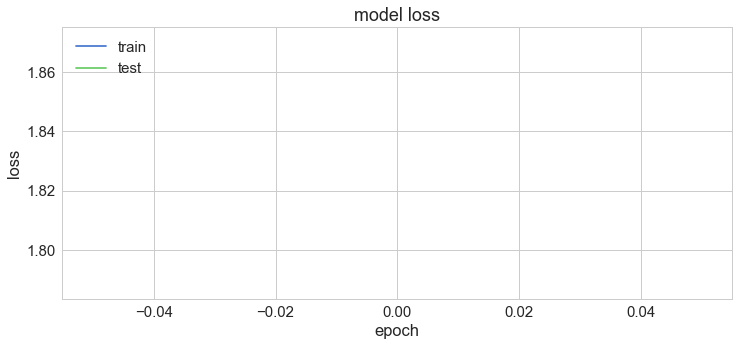

In [72]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [73]:
# create one-hot represetntation of input (will be padded with 0 vectors if text < SEQUENCE_LENGTH chars)
def prepare_input_old(text):
    print("will prepare: ", text)
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))  

    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [74]:
# changes "oldest" element in buffer to new element, then rolls the circular buffer 
def shift(c,condval,buf) :
    buf[0,0].fill(0)
    buf[0,0,char_indices[c]]=1
    buf[0,0,-lenconditional:]=condval
    buf[0]=np.roll(buf[0],-1, 0)
    return buf
    
# create one-hot represetntation of input (will be padded with 0 vectors if text < SEQUENCE_LENGTH chars)
def prepare_input(text,condval):
    print("will prepare: ", text)
    x = np.zeros((1, SEQUENCE_LENGTH, lenAugmentedInput))  
    for t, char in enumerate(text):
        shift(char, condval, x)      
    return x

In [75]:
# preds is an array of scores greater than 0 for each letter
# sample(preds) return the indexes of the n highest
#
# NOTE: If you aren't going to throw the dice, why not just take the 3 largest in the preds array directly?
#
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    #print('preds are ', preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take) # 3rd arg is a 1-arg function used as key for sorting

In [76]:
# preds is an array of scores unnormalized scores (logits)
# rsample(preds) Selects top_n, then throws dice to choose them in a randomized order based on their relative prob.

def rsample(preds, top_n=3, verbose=0):
    preds = np.asarray(preds).astype('float64')
    
    exp_preds = np.exp(preds)
    #sm=np.sum(exp_preds)
    preds = exp_preds / exp_preds.sum(0)
    
    # indexes of largest vals in preds, orders large to small
    idx = heapq.nlargest(top_n, range(len(preds)), preds.take)
    # and their values
    vals = np.take(preds, idx )
    #normalized (for np.random.choice)
    vals=vals/vals.sum(0)
    
    if (verbose == 1) :
        print("probability vals are ", vals)
    your_samples = np.random.choice(idx, size=top_n, replace=False,p=vals)
    return your_samples


In [77]:
# test sampling the probablity distribution
bar=[2,2,3,4,5,6]
rs = rsample(bar, top_n=3, verbose=1)
print("rsample: ", rs)
print("sample: ", sample(bar))
count=np.zeros(len(bar))
for i in range(10000) :
    foo=rsample(bar, top_n=topN)
    #foo=sample(bar, top_n=topN)
    #print("foo = ", foo)
    for j in range(len(bar)) :
        if j == foo[0] :
            count[j]=count[j]+1

for j in range(len(bar)) :
    print(" count ", str(j), " = ", str(count[j]))
    

probability vals are  [ 0.66524096  0.24472847  0.09003057]
rsample:  [5 4 3]
sample:  [5, 4, 3]
 count  0  =  0.0
 count  1  =  0.0
 count  2  =  0.0
 count  3  =  0.0
 count  4  =  0.0
 count  5  =  10000.0


In [78]:
def predict_completion_old(text):
    print("predict_completion for: ", text)
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = rsample(preds, top_n=topN)[0] # SAMPLE
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        print("len is ", len(original_text + completion))
        if (len(original_text + completion) + 2 > len(original_text) and next_char == ' ') or (len(original_text + completion) > 100) : 
            return completion

In [79]:
def wordEnd(c) :
    if c in [' ', ';', '.', '!', ',', '?'] : 
        return True
    else :
        return False

def predict_completion(text, condval):
    print("predict_completion for: ", text)
    original_text = text
    generated = text
    completion = ''

    next_char=text[-1]
    
    x = prepare_input(text, condval)
    while True:
        
        preds = model.predict(x, verbose=0)[0]
        
        if (wordEnd(next_char)) : #if we are about to start a new word
            next_index = rsample(preds, top_n=topNStartWord)[0] # SAMPLE
        else :
            #can add a little more randomness so we don't get stuck in repetitions at the word level
            next_index = rsample(preds, top_n=topN)[0] # SAMPLE
                
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        

        if len(original_text + completion) > k_phraseLength : 
            print("Extended text is : ", original_text + completion)
            return completion
        
        #if (len(original_text + completion) + 2 > len(original_text) and next_char == ' ') or (len(original_text + completion) > k_phraseLength100) :
        #    return completion
        
        x=shift(next_char, condval, x)
        

In [80]:
# predict n different completions for the first 40 characters of text.
def predict_completions(text, condval, n=3 ):
    x = prepare_input(text, condval)
    preds = model.predict(x, verbose=0)[0]
    next_indices = rsample(preds, n)  # SAMPLE (for the character folloiwng the input)
    print("Will predict completions for the indices : ", [indices_char[idx] for idx in next_indices])
    return [indices_char[idx] + predict_completion(text[0:] + indices_char[idx], condval) for idx in next_indices]


In [81]:
quotes = [
    "after you hear the word eleph",
    "friendship that makes unhappy ",
    "That which does not kill us makes us "
]

for q in quotes:
    seq = q[-SEQUENCE_LENGTH:].lower()
    print(seq)
    print("... and the completions are : " , predict_completions(seq, k_condCarroll, 5 ))
    print()

eleph
will prepare:  eleph
Will predict completions for the indices :  ['$', 'd', ']', "'", 'y']
predict_completion for:  eleph$
will prepare:  eleph$
Extended text is :  eleph$''i']']]ttttt''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''
predict_completion for:  elephd
will prepare:  elephd
Extended text is :  elephd]'t'tt''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y
predict_completion for:  eleph]
will prepare:  eleph]
Extended text is :  eleph]]ttttt''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y
predict_completion for:  eleph'
will prepare:  eleph'
Extended text is :  eleph'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y
predict_completion for:  elephy
will prepare:  elephy
Extended text is :  elephy''t'''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y'''''y''''
... and the completions

In [82]:
quotes = [
    "after you hear the word eleph",
    "friendship that makes unhappy ",
    "That which does not kill us makes us "
]

for q in quotes:
    seq = q[-SEQUENCE_LENGTH:].lower()
    print(seq)
    print("... and the completions are : " , predict_completions(seq, k_condNietzsche, 5 ))
    print()
    

eleph
will prepare:  eleph
Will predict completions for the indices :  ['w', 'n', 'd', '$', ',']
predict_completion for:  elephw
will prepare:  elephw
Extended text is :  elephw,,,e$jjjjllccbwmcce'''ynen''w'weeyy$n$$$jjjjllccbwmcce'''ynen''w'weeyy$n$$$jjjjllccbwmcce'''yne
predict_completion for:  elephn
will prepare:  elephn
Extended text is :  elephnw'ww'eeyyn$$$wjj$cclcmm,e'',ynnn''wwweey$$n$$jjjjllccbwmcce'''ynen''w'weeyy$n$$$jjjjllccbwmcce'
predict_completion for:  elephd
will prepare:  elephd
Extended text is :  elephdwweweyy$$$$$jjjjllccbwmcce'''ynen''w'weeyy$n$$$jjjjllccbwmcce'''ynen''w'weeyy$n$$$jjjjllccbwmcc
predict_completion for:  eleph$
will prepare:  eleph$
Extended text is :  eleph$,,,ljjjncccccmm''eeennnjjcccccmm''eeennnjjcccccmm''eeennnjjcccccmm''eeennnjjcccccmm''eeennnjjcc
predict_completion for:  eleph,
will prepare:  eleph,
Extended text is :  eleph,$,,,jjjjllccbwmcce'''ynen''w'weeyy$n$$$jjjjllccbwmcce'''ynen''w'weeyy$n$$$jjjjllccbwmcce'''ynen
... and the completions

In [83]:
quotes = [
    "after you hear the word eleph",
    "friendship that makes unhappy ",
    "That which does not kill us makes us "
]

for q in quotes:
    seq = q[-SEQUENCE_LENGTH:].lower()
    print(seq)
    print("... and the completions are : " , predict_completions(seq, k_condShakespeare, 5 ))
    print()

eleph
will prepare:  eleph
Will predict completions for the indices :  ['r', "'", 'n', 'f', ']']
predict_completion for:  elephr
will prepare:  elephr
Extended text is :  elephr'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
predict_completion for:  eleph'
will prepare:  eleph'
Extended text is :  eleph''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
predict_completion for:  elephn
will prepare:  elephn
Extended text is :  elephn'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
predict_completion for:  elephf
will prepare:  elephf
Extended text is :  elephf'''r'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
predict_completion for:  eleph]
will prepare:  eleph]
Extended text is :  eleph]'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
... and the completions